In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

In [3]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (352, 480)

In [4]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [5]:
camvid32 = camvid.CamVid(target_size=target_size, crop_size=coarse_crop)
generators = camvid32.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


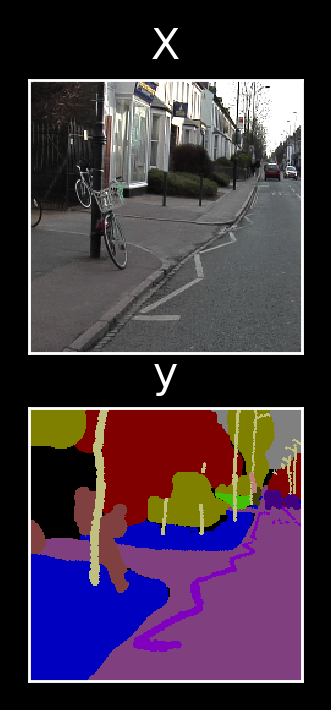

In [6]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid32.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [7]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid32.n,
    label_names=camvid32.discrete_to_label_map,
    learning_rate=1e-3,
)

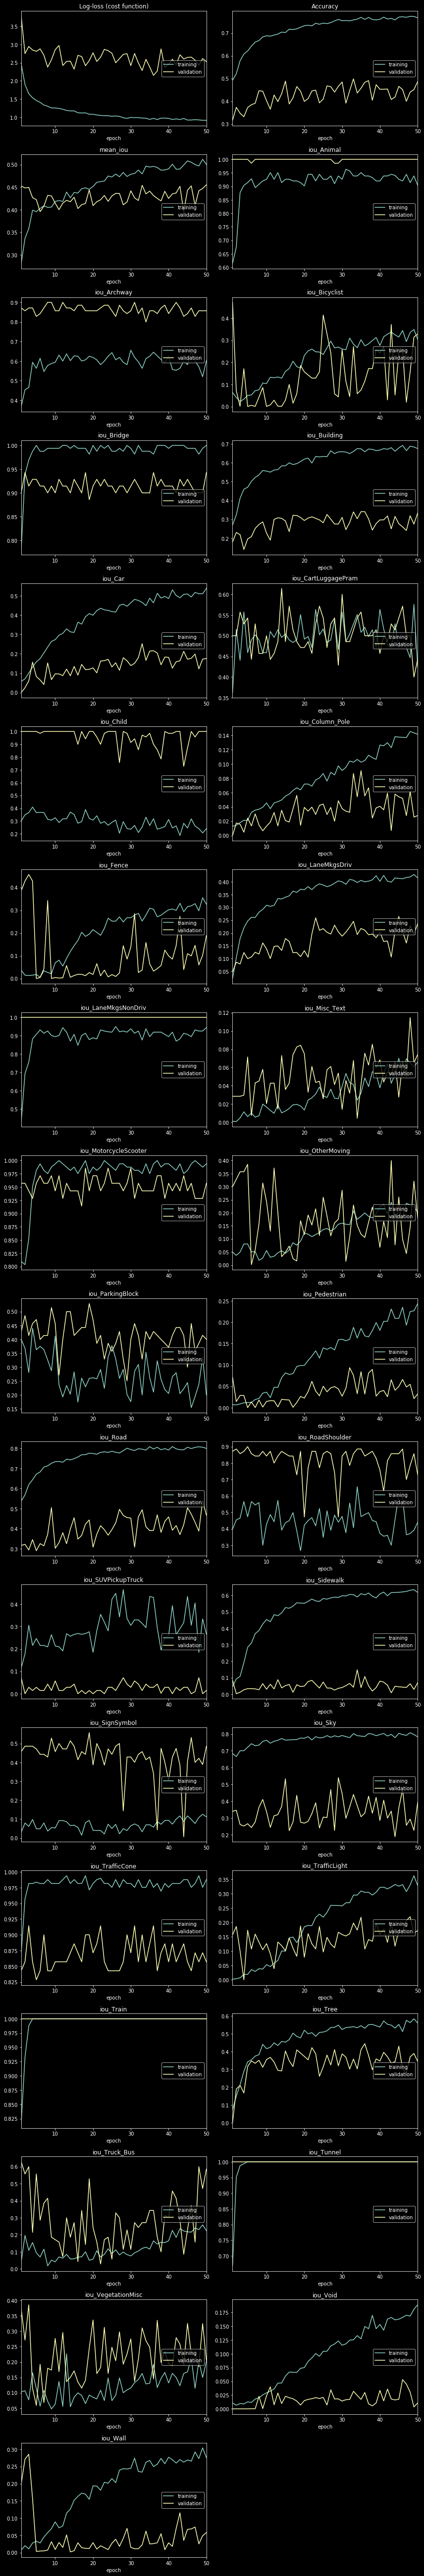

In [8]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [9]:
history_to_results(history)

train       val
acc                0.766833  0.486519
Animal             0.903689  1.000000
Archway            0.602525  0.857143
Bicyclist          0.303980  0.328571
Bridge             1.000000  0.942857
Building           0.675337  0.333630
Car                0.538100  0.175975
CartLuggagePram    0.424180  0.442857
Child              0.240896  1.000000
Column_Pole        0.141654  0.027910
Fence              0.327001  0.188881
LaneMkgsDriv       0.415251  0.236398
LaneMkgsNonDriv    0.944672  1.000000
Misc_Text          0.066035  0.074309
MotorcycleScooter  0.993852  0.957143
OtherMoving        0.201192  0.180444
ParkingBlock       0.200186  0.400478
Pedestrian         0.243616  0.032023
Road               0.800697  0.467181
RoadShoulder       0.439168  0.728571
SUVPickupTruck     0.266465  0.014286
Sidewalk           0.618378  0.069411
SignSymbol         0.112847  0.485826
Sky                0.783451  0.393477
TrafficCone        0.987705  0.857143
TrafficLight       0.328701  0.171896
Train              1.000000  1.000000
Tree               0.559355  0.343521
Truck_Bus          0.224636  0.585714
Tunnel             1.000000  1.000000
VegetationMisc     0.201999  0.205070
Void               0.188679  0.010763
Wall               0.275866  0.058081
loss               0.916525  2.530202
mean_iou           0.500316  0.455299

In [10]:
metrics = model.evaluate_generator(generators['validation'], steps=210)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

val
loss                   1.780013
acc                    0.584270
mean_iou               0.474118
iou_Animal             1.000000
iou_Archway            0.871429
iou_Bicyclist          0.219048
iou_Bridge             0.923810
iou_Building           0.382263
iou_Car                0.218119
iou_CartLuggagePram    0.514286
iou_Child              1.000000
iou_Column_Pole        0.039916
iou_Fence              0.155346
iou_LaneMkgsDriv       0.307310
iou_LaneMkgsNonDriv    1.000000
iou_Misc_Text          0.099573
iou_MotorcycleScooter  0.952381
iou_OtherMoving        0.206660
iou_ParkingBlock       0.367435
iou_Pedestrian         0.059499
iou_Road               0.611117
iou_RoadShoulder       0.714286
iou_SUVPickupTruck     0.038095
iou_Sidewalk           0.048410
iou_SignSymbol         0.476190
iou_Sky                0.526569
iou_TrafficCone        0.876190
iou_TrafficLight       0.179695
iou_Train              1.000000
iou_Tree               0.446925
iou_Truck_Bus          0.576190
iou_Tunnel             1.000000
iou_VegetationMisc     0.314402
iou_Void               0.015104
iou_Wall               0.031531

In [11]:
X, y = next(generators['training'])
y = camvid32.unmap(y)
p = model.predict(X)
p = camvid32.unmap(p)

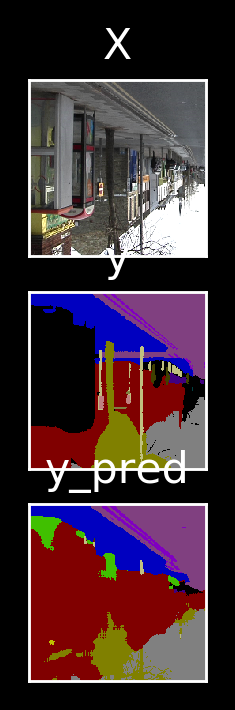

In [12]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

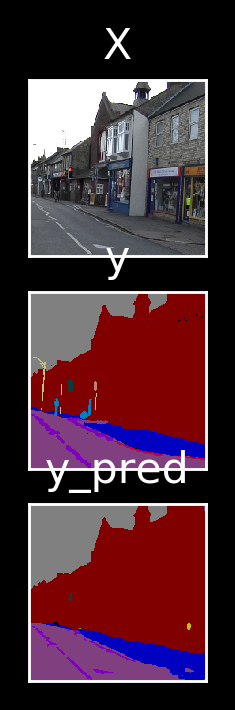

In [13]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

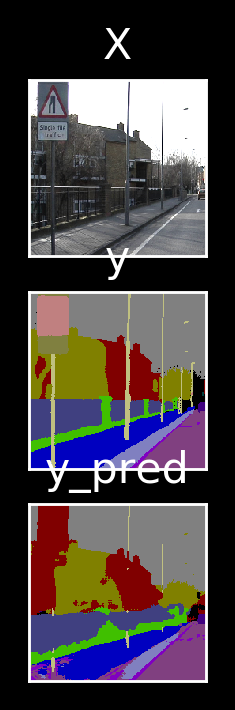

In [14]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

In [15]:
X, y = next(generators['validation'])
y = camvid32.unmap(y)
p = model.predict(X)
p = camvid32.unmap(p)

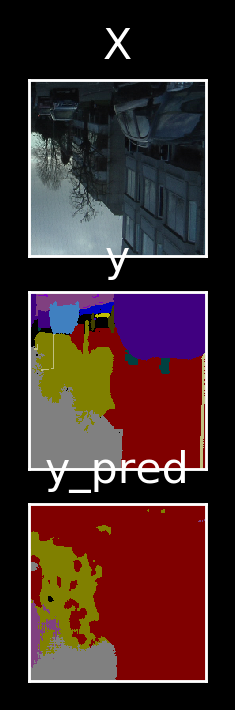

In [16]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

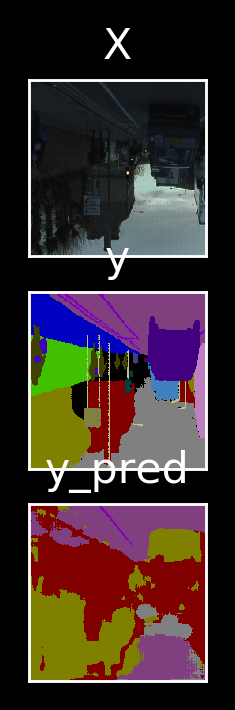

In [17]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

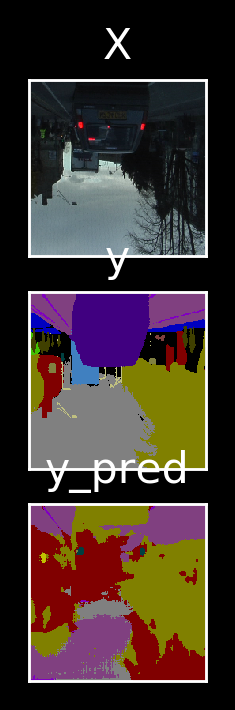

In [18]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

## Save Model

In [19]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid32-coarse.h5')

# Clear Session

remove the current model from memory.

In [20]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [21]:
camvid32 = camvid.CamVid(target_size=target_size, crop_size=fine_crop, batch_size=1)
generators = camvid32.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


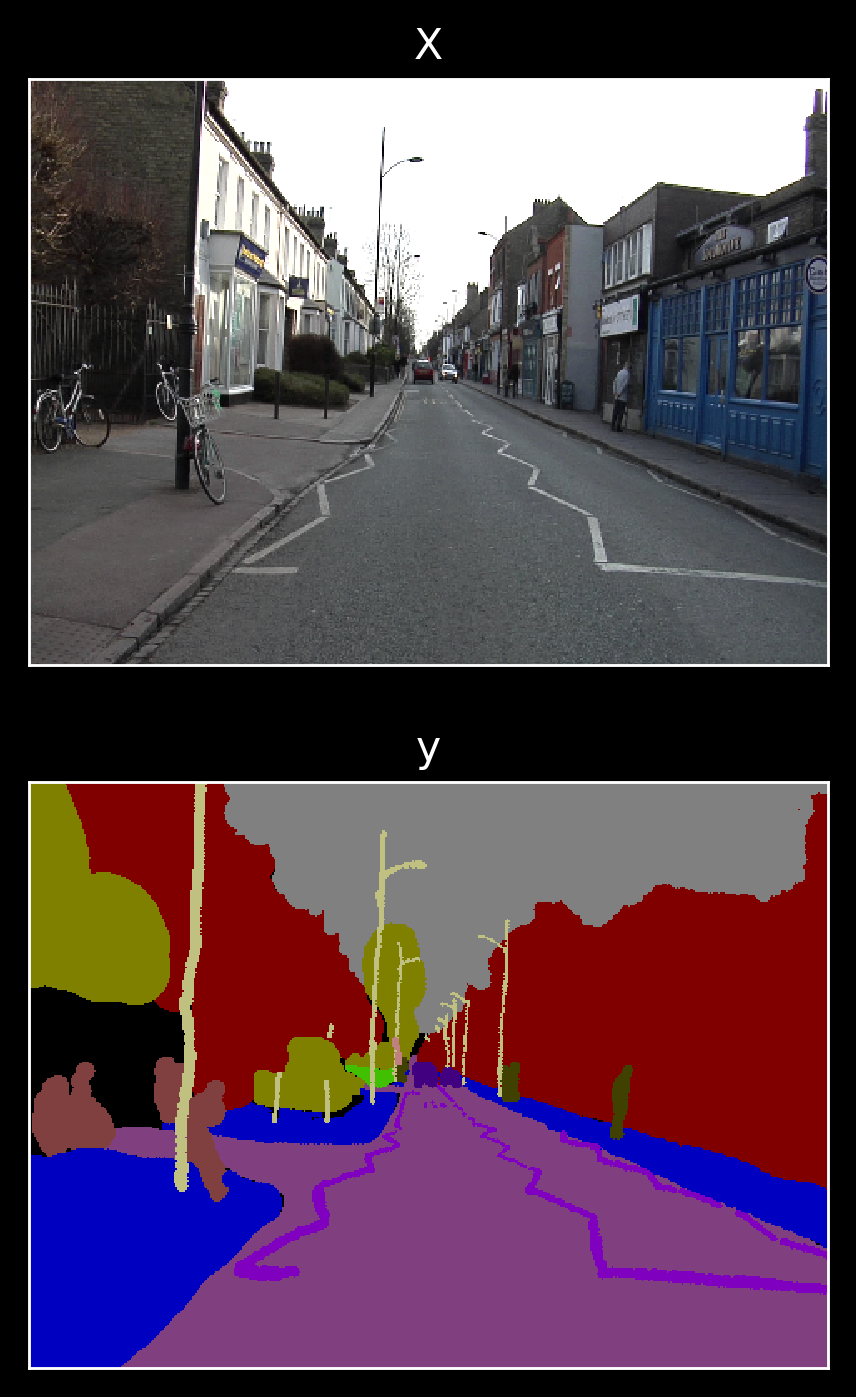

In [22]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid32.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [23]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid32.n,
    label_names=camvid32.discrete_to_label_map,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid32-coarse.h5')

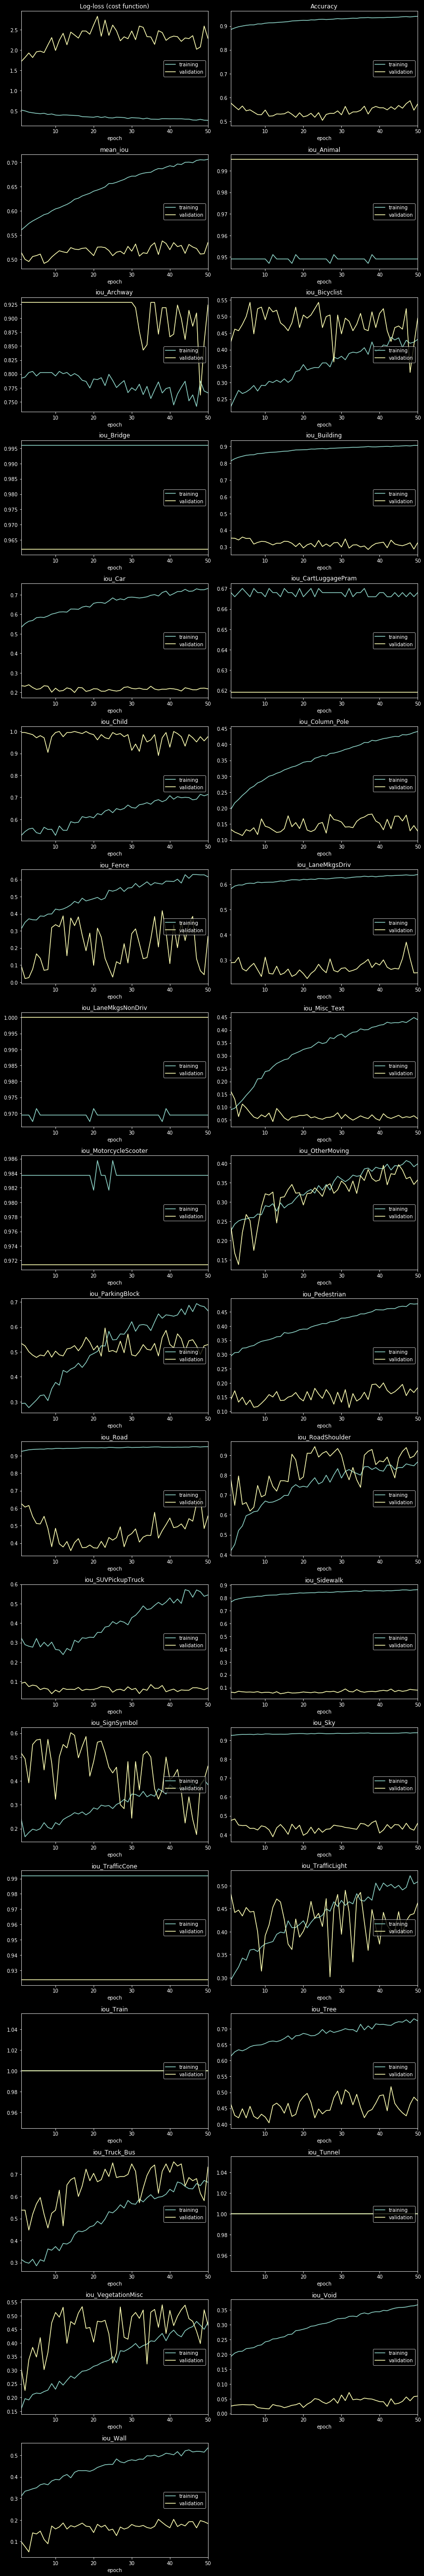

In [24]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=491,
    validation_data=generators['validation'],
    validation_steps=210,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [25]:
history_to_results(history)

train       val
acc                0.940584  0.573193
Animal             0.949084  0.995238
Archway            0.765969  0.923810
Bicyclist          0.430805  0.495238
Bridge             0.995927  0.961905
Building           0.906299  0.326103
Car                0.731779  0.218550
CartLuggagePram    0.668038  0.619048
Child              0.713069  0.976190
Column_Pole        0.440687  0.127904
Fence              0.616186  0.267265
LaneMkgsDriv       0.638901  0.249953
LaneMkgsNonDriv    0.969450  1.000000
Misc_Text          0.440391  0.055323
MotorcycleScooter  0.983707  0.971429
OtherMoving        0.398963  0.357153
ParkingBlock       0.665195  0.529124
Pedestrian         0.477871  0.183248
Road               0.951924  0.555336
RoadShoulder       0.866327  0.923810
SUVPickupTruck     0.545106  0.067301
Sidewalk           0.864505  0.080159
SignSymbol         0.384549  0.461907
Sky                0.939213  0.461177
TrafficCone        0.991853  0.923810
TrafficLight       0.508491  0.462518
Train              1.000000  1.000000
Tree               0.725041  0.472990
Truck_Bus          0.664413  0.733333
Tunnel             1.000000  1.000000
VegetationMisc     0.476038  0.465321
Void               0.367286  0.059157
Wall               0.534389  0.183614
loss               0.266944  2.283904
mean_iou           0.706608  0.534622

In [26]:
metrics = tune_model.evaluate_generator(generators['validation'], steps=210)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

val
loss                   2.260651
acc                    0.574637
mean_iou               0.532636
iou_Animal             0.995238
iou_Archway            0.914286
iou_Bicyclist          0.476190
iou_Bridge             0.957143
iou_Building           0.325219
iou_Car                0.221473
iou_CartLuggagePram    0.619048
iou_Child              0.971429
iou_Column_Pole        0.129600
iou_Fence              0.252261
iou_LaneMkgsDriv       0.251791
iou_LaneMkgsNonDriv    1.000000
iou_Misc_Text          0.057317
iou_MotorcycleScooter  0.971429
iou_OtherMoving        0.355676
iou_ParkingBlock       0.529081
iou_Pedestrian         0.178085
iou_Road               0.553283
iou_RoadShoulder       0.900000
iou_SUVPickupTruck     0.069617
iou_Sidewalk           0.082412
iou_SignSymbol         0.476190
iou_Sky                0.459560
iou_TrafficCone        0.919048
iou_TrafficLight       0.457983
iou_Train              1.000000
iou_Tree               0.476796
iou_Truck_Bus          0.733333
iou_Tunnel             1.000000
iou_VegetationMisc     0.469454
iou_Void               0.057503
iou_Wall               0.183900

In [27]:
X, y = next(generators['training'])
y = camvid32.unmap(y)
p = tune_model.predict(X)
p = camvid32.unmap(p)

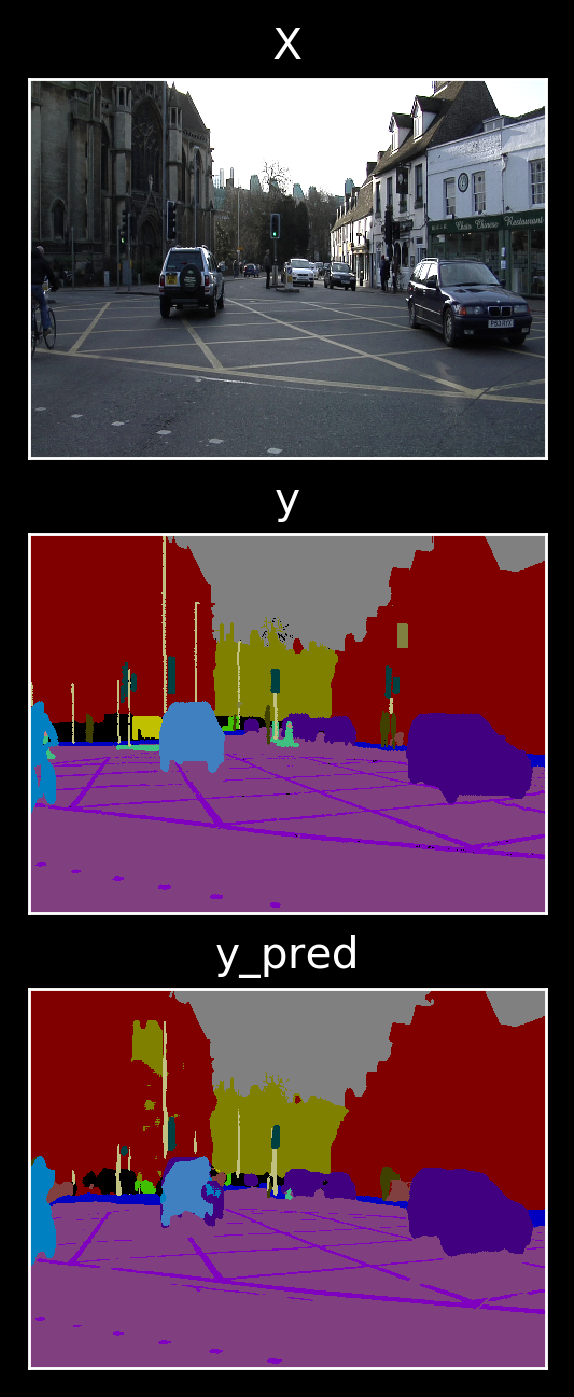

In [28]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [29]:
X, y = next(generators['validation'])
y = camvid32.unmap(y)
p = tune_model.predict(X)
p = camvid32.unmap(p)

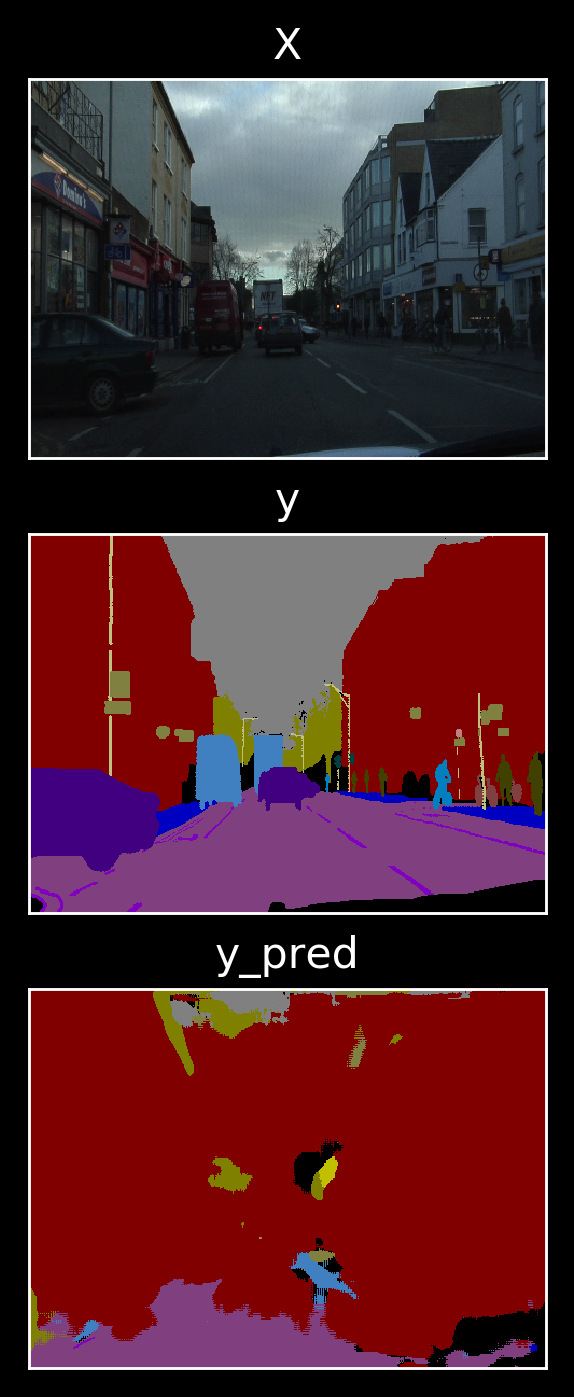

In [30]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [31]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid32-fine.h5')